In [ ]:
#Kevin Wang project (Monte Carlos Simulation with FB Retracement)
#Imports
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from scipy.optimize import minimize
plt.style.use('ggplot')

In [ ]:
#default stocks (Virginia Tech Energy Portfolio)
portfolio = ['XOM','CVX','KMI','CEG','D','DUK','XLE']
portfolio_shares = [198,252,747,405,1116,843,1252]
prices = []
total = []
weight_port = []
#Start purchase date
start = '01/01/2020'
#Today's date
today = dt.today().strftime('%Y-%m-%d')

In [ ]:
#Weights the portfolio
for shares in portfolio_shares:
    weighted = shares/sum(portfolio_shares)
    weight_port.append(weighted)
print(weight_port)
#Array for weight
weight_port_array = np.array(weight_port)

[0.04113858300436318, 0.05235819655100769, 0.15520465406191564, 0.08414710159983378, 0.23187201329731977, 0.17515063370039477, 0.26012881778516517]


In [ ]:
#Pulls Data from yahoo finance
df = pdr.get_data_yahoo(portfolio,start,today)
#Picks only the adjusted close
close = df['Adj Close']
##Fills NAs with zeros
df_close = close.dropna()#.fillna(0)
df_close

Symbols,XOM,CVX,KMI,CEG,D,DUK,XLE
Date,,,,,,,
2022-01-19,70.320381,124.427887,16.389364,41.621311,77.111122,98.317329,62.305138
2022-01-20,70.474281,123.983879,16.389364,44.594261,77.169670,98.452057,61.733440
2022-01-21,69.416245,122.497429,16.332945,44.594261,77.384315,99.096786,60.512527
2022-01-24,70.012604,122.758034,16.285929,42.414097,76.574478,98.711868,60.919498
2022-01-25,72.070938,127.979935,16.455185,41.520229,76.086624,98.461678,63.283794
...,...,...,...,...,...,...,...
2022-11-25,113.209999,183.699997,18.629999,97.160004,61.529999,99.620003,91.870003
2022-11-28,109.809998,178.360001,18.459999,94.809998,60.619999,98.610001,89.349998
2022-11-29,110.540001,181.029999,18.879999,94.430000,59.770000,97.940002,90.699997


In [ ]:
#Creates dictionary of stock and ticker
ticker_shares = dict((portfolio,portfolio_shares) for portfolio,portfolio_shares in zip(portfolio,portfolio_shares))
ticker_shares

{'XOM': 198,
 'CVX': 252,
 'KMI': 747,
 'CEG': 405,
 'D': 1116,
 'DUK': 843,
 'XLE': 1252}

In [ ]:
portfolio_returns = []
for ticker in df_close:
    first = df_close[ticker].iloc[0]
    last = df_close[ticker].iloc[-1]
    shares = ticker_shares[ticker]
    profit = (last - first) * shares
    portfolio_returns.append(profit)
    
#Portfolio returns
portfolio_returns

[8014.965133666992,
 14631.653869628906,
 2062.194625854492,
 21403.71946334839,
 -18683.093490600586,
 1679.8192520141602,
 35738.165771484375]

In [ ]:
#Takes out the first row and takes daily returns
daily_rtn = df_close.pct_change()[1:]
daily_rtn

Symbols,XOM,CVX,KMI,CEG,D,DUK,XLE
Date,,,,,,,
2022-01-20,0.002189,-0.003568,0.000000,0.071429,0.000759,0.001370,-0.009176
2022-01-21,-0.015013,-0.011989,-0.003442,0.000000,0.002781,0.006549,-0.019777
2022-01-24,0.008591,0.002127,-0.002879,-0.048889,-0.010465,-0.003884,0.006725
2022-01-25,0.029399,0.042538,0.010393,-0.021075,-0.006371,-0.002535,0.038810
2022-01-26,-0.010143,0.000754,0.001143,0.031553,-0.006669,-0.003616,-0.001684
...,...,...,...,...,...,...,...
2022-11-25,-0.003521,-0.002931,-0.001072,0.005589,0.008193,0.010960,-0.003687
2022-11-28,-0.030033,-0.029069,-0.009125,-0.024187,-0.014790,-0.010139,-0.027430
2022-11-29,0.006648,0.014970,0.022752,-0.004008,-0.014022,-0.006794,0.015109


In [ ]:
#Sensitivity Analysis
corr = daily_rtn.corr()
corr

Symbols,XOM,CVX,KMI,CEG,D,DUK,XLE
Symbols,,,,,,,
XOM,1.000000,0.880814,0.760027,0.302023,0.245817,0.238918,0.953866
CVX,0.880814,1.000000,0.758390,0.321647,0.252379,0.256029,0.932835
KMI,0.760027,0.758390,1.000000,0.399839,0.446312,0.436502,0.832062
CEG,0.302023,0.321647,0.399839,1.000000,0.380672,0.405485,0.335391
D,0.245817,0.252379,0.446312,0.380672,1.000000,0.834826,0.254895
DUK,0.238918,0.256029,0.436502,0.405485,0.834826,1.000000,0.250341
XLE,0.953866,0.932835,0.832062,0.335391,0.254895,0.250341,1.000000


In [ ]:
#Cumulative returns
cum_rtn = (((1+daily_rtn).cumprod()-1)*100)
cum_rtn

Symbols,XOM,CVX,KMI,CEG,D,DUK,XLE
Date,,,,,,,
2022-01-20,0.218856,-0.356840,0.000000,7.142855,0.075927,0.137033,-0.917576
2022-01-21,-1.285739,-1.551467,-0.344244,7.142855,0.354285,0.792797,-2.877147
2022-01-24,-0.437679,-1.342025,-0.631114,1.904759,-0.695936,0.401291,-2.223957
2022-01-25,2.489402,2.854704,0.401606,-0.242861,-1.328600,0.146819,1.570748
2022-01-26,1.449870,2.932281,0.516342,2.904761,-1.986592,-0.215316,1.399689
...,...,...,...,...,...,...,...
2022-11-25,60.991731,47.635712,13.671274,133.438114,-20.206065,1.324968,47.451729
2022-11-28,56.156716,43.344073,12.634016,127.791953,-21.386180,0.297680,43.407112
2022-11-29,57.194826,45.489892,15.196654,126.878966,-22.488483,-0.383785,45.573865


In [ ]:
#Cumulative returns (Weighted for Portfolio)
cum_rtn_w = (((1+daily_rtn).cumprod()-1)*100)*weight_port
#cum_rtn_w.iloc[cum_rtn_w.loc['CEG'].isnull()]

In [ ]:
cum_rtn_w['PortfolioReturns'] = cum_rtn_w[portfolio].sum(axis=1)
#(1+weighted_port_rtns).cumprod()
cum_rtn_w

Symbols,XOM,CVX,KMI,CEG,D,DUK,XLE,PortfolioReturns
Date,,,,,,,,
2022-01-20,0.009003,-0.018683,0.000000,0.601051,0.017605,0.024001,-0.238688,0.394289
2022-01-21,-0.052893,-0.081232,-0.053428,0.601051,0.082149,0.138859,-0.748429,-0.113924
2022-01-24,-0.018005,-0.070266,-0.097952,0.160280,-0.161368,0.070286,-0.578515,-0.695540
2022-01-25,0.102410,0.149467,0.062331,-0.020436,-0.308065,0.025715,0.408597,0.420020
2022-01-26,0.059646,0.153529,0.080139,0.244427,-0.460635,-0.037713,0.364099,0.403492
...,...,...,...,...,...,...,...,...
2022-11-25,2.509113,2.494120,2.121845,11.228430,-4.685221,0.232069,12.343562,26.243920
2022-11-28,2.310208,2.269417,1.960858,10.753322,-4.958857,0.052139,11.291441,23.678529
2022-11-29,2.352914,2.381769,2.358591,10.676497,-5.214450,-0.067220,11.855076,24.343177


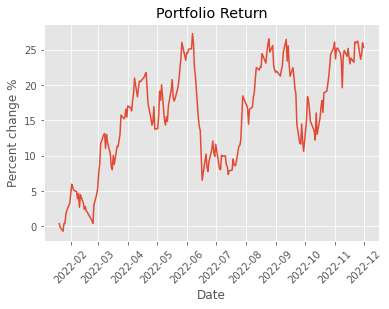

In [ ]:
plt.title('Portfolio Return')
plt.xlabel('Date')
plt.xticks(rotation =45)
plt.ylabel('Percent change %')
plt.plot(cum_rtn_w['PortfolioReturns'])
plt.show()

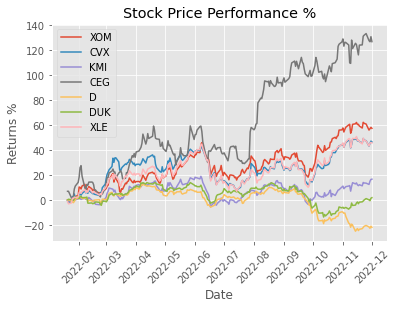

In [ ]:
#Shows Stock pricer performance
plt.title('Stock Price Performance %')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Returns %')
plt.plot(cum_rtn)
plt.legend(portfolio)
plt.show()

[]

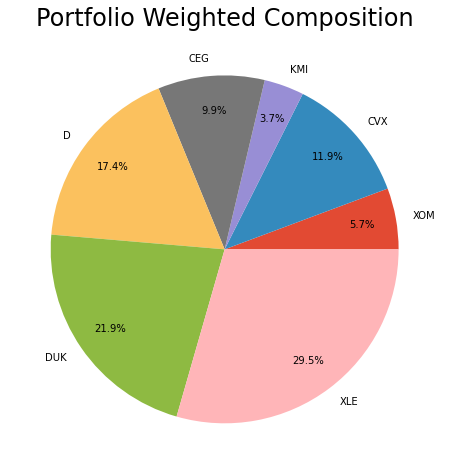

In [ ]:
#Creates a pie chart portfolio of stocks and weights
for stock in portfolio:
    port = pdr.get_data_yahoo(stock, start = start,end =today)
    price = port[-1:]['Adj Close'][0]
    prices.append(price)
    index = portfolio.index(stock)
    total.append(price*portfolio_shares[index])

#Plots pie chart of portfolio
figure, axis = plt.subplots(figsize=(8,8))
axis.set_facecolor('white')
axis.figure.set_facecolor('white')

axis.tick_params(axis='x',color = 'white')
axis.tick_params(axis='y',color = 'white')
axis.set_title('Portfolio Weighted Composition',color='black',fontsize=24)
patches,texts,autotexts = axis.pie(total,labels=list(portfolio),autopct='%1.1f%%',pctdistance=0.8)
plt.plot()

In [ ]:
port_today = sum(total)
#Portfolio Value today
port_val = port_today
#Sorts data into ascending order
port_df = df['Adj Close']
#Calculates normal percent change
normal_rtns = port_df/port_df.iloc[0]
#normal returns
normal_wrtns = normal_rtns * weight_port
weighted_port = normal_wrtns * port_val
#Adds to a new dataframe column
portfolio_val = weighted_port

portfolio_val = weighted_port
portfolio_val['Total Value'] = portfolio_val.sum(axis=1)
portfolio_val['Daily Return'] = portfolio_val['Total Value'].pct_change(1)
portfolio_val

###Portfolio stats###
print(f'Your portfolio is worth ${round((port_today),2)} today')
print(f'The stocks in your portfolio are {portfolio}')
#Sharp Ratio
sharp = portfolio_val['Daily Return'].mean() / portfolio_val['Daily Return'].std()
print(f'The current sharpe ratio is {sharp}')
print(f'The annualized sharp ratio is {sharp*(252**.5)}')

#Cumulative returns
cum_rtn = 100 * (portfolio_val['Total Value'][-1]/portfolio_val['Total Value'][0] -1 )
print(f'Cumulative return is {cum_rtn.round(2)}%')

#Daily return mean
portfolio_val['Daily Return'].mean()

#Daily return standard deviation
portfolio_val['Daily Return'].std()


#print(f'Your portfolio has performed {port_change}% compared to the start')
#print(f'You have lost or gained ${round(sum(portfolio_returns),2)} in your portfolio')
print(f'The stock performance are as follows:\n  {daily_rtn.sum()}')

Your portfolio is worth $386169.73 today
The stocks in your portfolio are ['XOM', 'CVX', 'KMI', 'CEG', 'D', 'DUK', 'XLE']
The current sharpe ratio is 0.0289423851143196
The annualized sharp ratio is 0.45944612016928427
Cumulative return is 30.67%
The stock performance are as follows:
  Symbols
XOM    0.511314
CVX    0.433570
KMI    0.189493
CEG    0.923657
D     -0.218123
DUK    0.042027
XLE    0.434222
dtype: float64


In [ ]:
D_rtn_df = pd.DataFrame()
daily_rtn_df = daily_rtn.sum()
D_rtn_df['Cumulative Returns'] = daily_rtn_df.to_frame()
D_rtn_df*100

,Cumulative Returns
Symbols,
XOM,51.131410
CVX,43.356984
KMI,18.949278
CEG,92.365663
D,-21.812323
DUK,4.202675
XLE,43.422221


In [ ]:
#Fibbonacci Retracement levels
#The levels are: 23.6%, 38.2%, 50%, 61.8%, 78.6%

#Creates a function for fibbonacci retracement
def fibbonacci_retracement():
    max_price = cum_rtn_w['PortfolioReturns'].max()
    min_price = cum_rtn_w['PortfolioReturns'].min()
    dif = max_price - min_price

    first_level = max_price - dif * 0.236
    second_level = max_price - dif * 0.382
    third_level = max_price - dif * 0.5
    fourth_level = max_price - dif * 0.618
    fifth_level = max_price - dif * 0.786
    
    data2 = cum_rtn_w
    #Plots Fibbonacci retracement
    plt.figure(figsize=(12,10))
    plt.subplot(2,1,1)
    plt.plot(data2.index,data2['PortfolioReturns'])
    plt.axhline(max_price,linestyle='dashed',alpha=1,color='green')
    plt.axhline(first_level,linestyle='dashed',alpha=1,color='purple')
    plt.axhline(second_level,linestyle='dashed',alpha=1,color='yellow')
    plt.axhline(third_level,linestyle='dashed',alpha=1,color='brown')
    plt.axhline(fourth_level,linestyle='dashed',alpha=1,color='red')
    plt.axhline(fifth_level,linestyle='dashed',alpha=1,color='orange')
    plt.title('Fibbonacci Retracement levels')
    plt.xlabel('Date')
    plt.ylabel('Percent Return %')
    plt.xticks(rotation=45)
    plt.show()

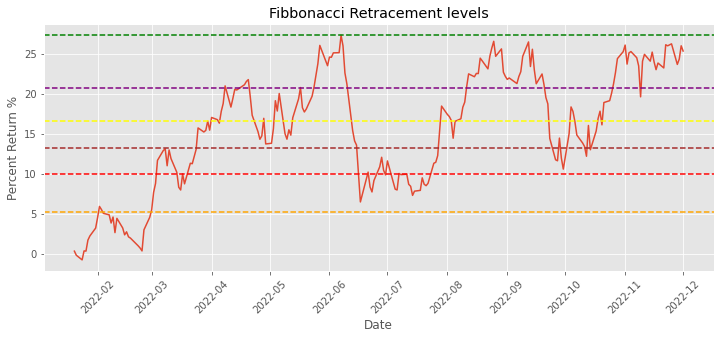

In [ ]:
#Calls and Plots the Fibbonacci Retracemnt function
fibbonacci_retracement()
#The levels are: 23.6%, 38.2%, 50%, 61.8%, 78.6%

In [ ]:
#Monte Carlos simulation

#Portfolio Value today
port_val = port_today

#Sorts data into ascending order
port_df = df['Adj Close']

#Calculates normal percent change
normal_rtns = port_df/port_df.iloc[0]
#normal returns
normal_wrtns = normal_rtns * weight_port

In [ ]:
#Logrithmic returns
log_ret = np.log(port_df/port_df.shift(1))

In [ ]:
portfolio_val = weighted_port

<AxesSubplot:xlabel='Date'>

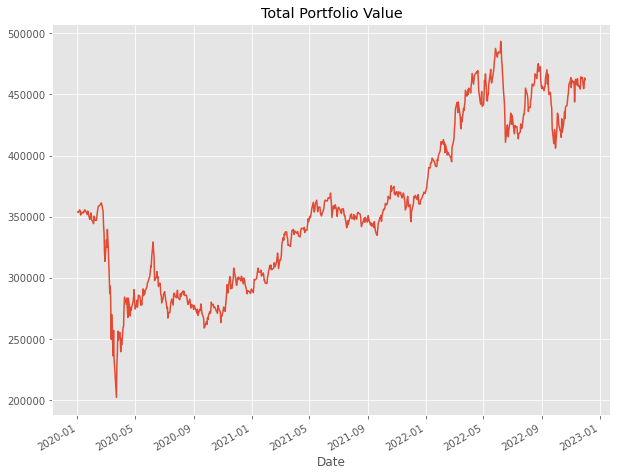

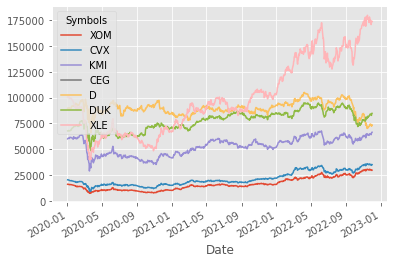

In [ ]:
#Plots the portfolio and creates dataframe

#weighted returns 
#based on CURRENT portfolio value
weighted_port = normal_wrtns * port_val
#Adds to a new dataframecolumn
portfolio_val = weighted_port
portfolio_val['Total Value'] = portfolio_val.sum(axis=1)
portfolio_val['Total Value'].plot(figsize=(10,8))
plt.title('Total Portfolio Value')
portfolio_val.drop('Total Value',axis=1).plot(kind='line')

In [ ]:
#The simulation

#Times we will run simulation
num_sim = 10000

#sets all variables to 0
all_weight = np.zeros(shape=(num_sim,len(port_df.columns)))
ret_arr = np.zeros(num_sim)
vol_arr = np.zeros(num_sim)
sharpe_arr = np.zeros(num_sim)

for trial in range(num_sim):
    #Creates random weights
    weight = np.array(np.random.random(len(weight_port)))
    #rebalances weight so it equals to 1
    weight = weight / np.sum(weight)
    # Save Weights
    all_weight[trial,:] = weight
    
    #Expected return, multiplied by 252 (Tradings days)
    ret_arr[trial] = np.sum(daily_rtn.mean() * weight) *252
    #Expected volatility
    vol_arr[trial] = np.sqrt(np.dot(weight.T, np.dot(log_ret.cov() * 252, weight)))
    #Sharpe Ratio
    sharpe_arr[trial] = ret_arr[trial]/vol_arr[trial]

In [ ]:
#Summary of Simulation
print(f'The stocks in the portfolio are {portfolio}')
print(f'The generated weights are {weight}')
print(f'The expected return of the portfolio is {ret_arr*100}%')
print(f'The expected volatility of the portfolio is {vol_arr*100}%')
print(f'The Sharpe Ratio is {sharpe_arr}')
print(f'The Minimum Sharpe Ratio was {round(sharpe_arr.min(),2)}')
print(f'The Maximum Sharpe Ratio was {round(sharpe_arr.max(),2)}')
#Sanity check
print({sum(weight)})

The stocks in the portfolio are ['XOM', 'CVX', 'KMI', 'CEG', 'D', 'DUK', 'XLE']
The generated weights are [0.10279252 0.02261058 0.17824808 0.21093864 0.09181795 0.15433485
 0.23925738]
The expected return of the portfolio is [36.61013823 34.26798875 53.26226695 ... 36.11114927 31.44661717
 43.8783278 ]%
The expected volatility of the portfolio is [29.32667307 29.95341796 35.16596817 ... 32.05180541 33.96421586
 30.77758152]%
The Sharpe Ratio is [1.24835634 1.14404269 1.51459692 ... 1.12664946 0.92587497 1.42565873]
The Minimum Sharpe Ratio was 0.12
The Maximum Sharpe Ratio was 2.15
{0.9999999999999998}


In [ ]:
#Index location of max Sharpe Value
optimal_port = int(sharpe_arr.argmax())
optimal_port

7242

In [ ]:
vol_arr.max()

0.39411060220710625

In [ ]:
#Maximum Sharp Ratio
sharpe_arr.max()

2.1530313935915784

In [ ]:
all_weight[optimal_port,:]

array([0.20553123, 0.10925588, 0.04957683, 0.4707981 , 0.01006568,
       0.03576185, 0.11901043])

C:\Users\wangk\AppData\Local\Temp\ipykernel_10036\1556436709.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe Ratio')


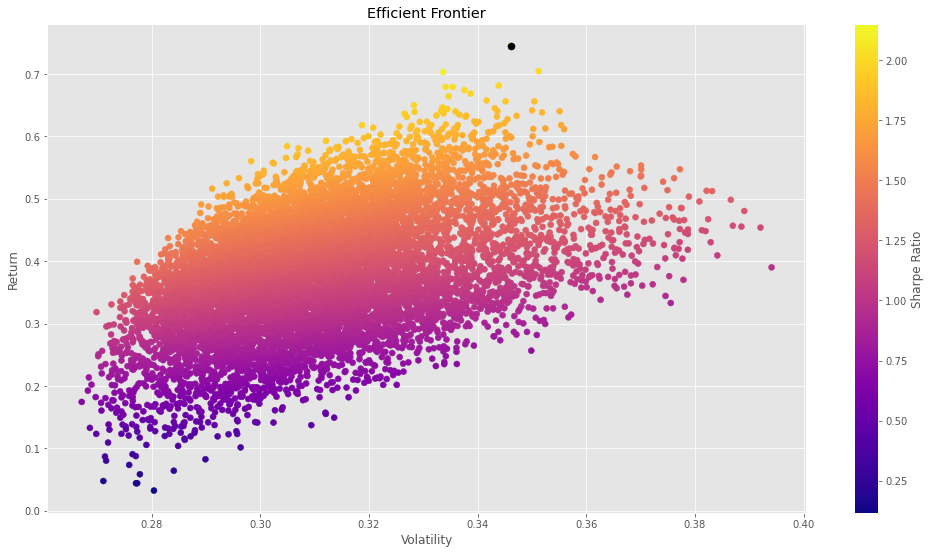

In [ ]:
#plots the simulation

#Efficient Frontier

#Change based on **sharpe_arr.argmax()
max_sr_ret = ret_arr[optimal_port]
max_sr_vol = vol_arr[optimal_port]
plt.figure(figsize=(17,9))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add black dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='black',s=50,edgecolors='black')

In [ ]:
#Function that gets return, volatility, and sharpe ratio
def get_rtn_vol_SR(weight):
    #Takes in weight & returns array of volatility, sharpe ratio, and mean return
    weight = np.array(weight)
    rtn = np.sum(log_ret.mean() * weight) * 252
    vol =np.sqrt(np.dot(weight.T, np.dot(log_ret.cov() * 252, weight)))
    #Sharp Ratio
    SR = rtn/vol
    return np.array([rtn,vol,SR])

In [ ]:
#Negative Sharpe Ratio (Takes in weight and returns sharpe ratio)
def neg_SR(weight):
    return  get_rtn_vol_SR(weight)[2] * - 1

In [ ]:
#Constraints
def check_sum(weight):
    #Returns 0 if sum is equal to = 1.0
    return np.sum(weight) - 1
#A function should return zeros ?
cond = ({'type':'eq','fun': check_sum})

#bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1),(0,1),(0,1),(0,1))

#creates an initial guess
int_guess = [0.1428,0.1428,0.1428,0.1428,0.1428,0.1428,0.1428]

#Sequential Least Squares Programming (SLSQP).
optimal_result = minimize(neg_SR,int_guess,method='SLSQP',bounds=bounds,constraints=cond)

In [ ]:
#Optimal portfolio weighting
opt = optimal_result.x
opt.round(4)
#stocks 1,2,3...

array([0., 0., 0., 1., 0., 0., 0.])

In [ ]:
get_rtn_vol_SR(optimal_result.x)
# 1- return, 2- volatility, 3- Sharpe Ratio

array([0.94318193, 0.48464745, 1.94611965])

C:\Users\wangk\AppData\Local\Temp\ipykernel_10036\1621741762.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe Ratio')


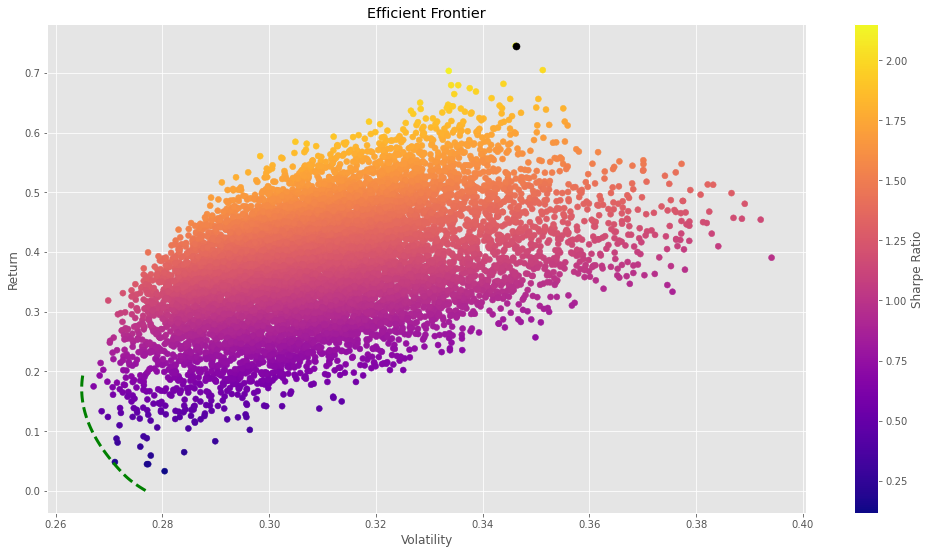

In [ ]:
#Plots the Efficient Frontier 
frontier_line = np.linspace(0,0.2,100) 

def min_vol(weight):
    return  get_rtn_vol_SR(weight)[1]
frontier_vol = []
for possible_rtn in frontier_line:
    # function for return
    cond = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_rtn_vol_SR(w)[0] - possible_rtn})
    
    result = minimize(min_vol,int_guess,method='SLSQP',bounds=bounds,constraints=cond)
    
    frontier_vol.append(result['fun'])
plt.figure(figsize=(17,9))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add black dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='black',s=50,edgecolors='black')
# Add frontier line
plt.plot(frontier_vol,frontier_line,'g--',linewidth=3)